# Air Quality Assessment in the Arctic
In this notebook we analyze the air quality in the arctic area using the data from ground stations located in European arctic

* Grundartangi Groef, Iceland (EEA st.52149) 
* Kopavogur Dalsmari, Iceland (EEA st.52109)
* Oulu Pyykoesjaervi, Finland (EEA st. 15557)
* Oulun Keskusta 2, Finland (EEA st. 15609)
* Tromso, Norway (EEA st. 62993) 
* Muonio Sammaltunturi, Finland (FMI st. 101983) 

The datasets are provided by the [Finnish Meteorological Institute (FMI)](https://en.ilmatieteenlaitos.fi/download-observations) and the [European Environmental Agency (EEA)](https://discomap.eea.europa.eu/map/fme/AirQualityExport.htm). The aim of the project is to build a model to predict the state of environmental variables such as the PM10. The prediction will be compared with that from the [CAMS service](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts). The prediction provided by the CAMS are the result of an ensemble of 9 air quality numerical models. An air quality model integrates a dynamical model of the atmosphere with the chemical-physical equations of the air components. The CAMS numerical models use as input the data assimilated from a network of ground stations and satellite sensors and return as output a grid that represents the horizontal and vertical distribution of the air quality variables with a prediction of their future state.      


In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## The datasets
Five of the 6 datasets can be downloaded from the EEA website by selecting the name of the country, the polluttant (PM10), and the years. Each station has a code number that can be used to filter out the files to be dowloaded. The dataset of the station managed by the FMI, Muonio Sammaltunturi, can be downloaded from the FMI website by selecting the hourly Air Quality observations of the Muonio Sammaltunturi meteorological institute for the inhalable particles <10 $\mu m$ and the time period.    


## The Muonio Sammaltunturi dataset
We use this dataset as a first exploration. Before the analysis we will perform a data preparation step by applying some transformation. The dataset is a subset of what is available from the FMI website and is related only to PM10. It contains a time series of hourly observation of the pollutant in $\mu g/m^3$  

In [84]:
path_muonio = 'data/fmi/101983/Muonio_Sammaltunturi.csv'
muonio_df_tmp = pd.read_csv(path_muonio)
muonio_df_tmp.head(3)

,Observation station,Year,Month,Day,Time [Local time],Inhalable particles <10 µm [µg/m3]
0,Muonio Sammaltunturi,2020,1,1,01:00,0
1,Muonio Sammaltunturi,2020,1,1,02:00,0
2,Muonio Sammaltunturi,2020,1,1,03:00,0


### Data preparation
We will apply some transformations to the datasets by aggregating some of its columns and removing those that are redundant 

In [85]:
year = muonio_df_tmp['Year']
month = muonio_df_tmp['Month']
day = muonio_df_tmp['Day']
time = muonio_df_tmp['Time [Local time]']

def ddigit(value):
    if (value < 10):
        return '0' + str(value)
    else:
        return str(value)

muonio_df_tmp['DateTime'] = year.apply(lambda year: str(year)) + '-' \
                  + month.apply(lambda month: ddigit(month)) + '-' \
                  + day.apply(lambda day: ddigit(day)) + ' ' \
                  + time.apply(lambda time: str(time)) + ':00'

In [86]:
muonio_df_tmp.head(3)

,Observation station,Year,Month,Day,Time [Local time],Inhalable particles <10 µm [µg/m3],DateTime
0,Muonio Sammaltunturi,2020,1,1,01:00,0,2020-01-01 01:00:00
1,Muonio Sammaltunturi,2020,1,1,02:00,0,2020-01-01 02:00:00
2,Muonio Sammaltunturi,2020,1,1,03:00,0,2020-01-01 03:00:00


We remove some fields that are redundant

In [87]:
muonio_df_tmp = muonio_df_tmp.drop(['Observation station', 'Year', 'Month', 'Day', 'Time [Local time]'], axis=1)
muonio_df_tmp.head(3)

,Inhalable particles <10 µm [µg/m3],DateTime
0,0,2020-01-01 01:00:00
1,0,2020-01-01 02:00:00
2,0,2020-01-01 03:00:00


We change the order of the fields

In [88]:
cols = muonio_df_tmp.columns.to_list()
cols = cols[-1:] + cols[:-1]
muonio_df_tmp = muonio_df_tmp[cols]
muonio_df_tmp.head(3)

,DateTime,Inhalable particles <10 µm [µg/m3]
0,2020-01-01 01:00:00,0
1,2020-01-01 02:00:00,0
2,2020-01-01 03:00:00,0


We rename the pollutant field

In [89]:
muonio_df_tmp = muonio_df_tmp.rename(columns={'Inhalable particles <10 µm [µg/m3]':'PM10'})
muonio_df_tmp.head(3)

,DateTime,PM10
0,2020-01-01 01:00:00,0
1,2020-01-01 02:00:00,0
2,2020-01-01 03:00:00,0


The values are stored as string so that we have to change the type into a float but before that we have to set all the string values that do not represent a number to NaN (Not a Number)

In [95]:
muonio_df_tmp[muonio_df_tmp['PM10'] == '-'] = 'NaN'

Now we can set the type of the column 'PM10' as float

In [97]:
muonio_df_tmp['PM10'] = muonio_df_tmp['PM10'].astype(float)

We want to use the DateTime field as the index of our time series

We want to aggregate the values of each day so that for each day we have the mean value of PM10 for that day

In [98]:
date_index = pd.to_datetime(muonio_df_tmp['DateTime'])
muonio_df_tmp.drop(['DateTime'], axis=1, inplace=True)
muonio_df = muonio_df_tmp.set_index(date_index)

Now we can select, for example, the observations for January 1st 2020 from midnight to 6 o' clock in the morning

In [99]:
muonio_df[:'2020-01-01 06:00:00']

,PM10
DateTime,
2020-01-01 01:00:00,0.0
2020-01-01 02:00:00,0.0
2020-01-01 03:00:00,0.0
2020-01-01 04:00:00,0.7
2020-01-01 05:00:00,0.2
2020-01-01 06:00:00,0.5


### Time series resampling
The data preparation step is completed. Now we want to aggregate the observations for each single day, that is we have to compute the mean value for each day from the hourly observations. This operation technically is called resampling and since we reduce the frequency yof the observation it is called more specifically downsampling. We resample the data by day and then by month

In [108]:
muonio_days_df = muonio_df.resample('D').mean()
muonio_days_df

,PM10
DateTime,
2020-01-01,0.978261
2020-01-02,1.033333
2020-01-03,3.045833
2020-01-04,0.830000
2020-01-05,0.008333
...,...
2022-12-28,1.279167
2022-12-29,0.575000
2022-12-30,2.486957


We resample by month and we can see that for March and April 2020 and February and March 2021 there are no observations

In [115]:
muonio_months_df = muonio_days_df.resample('M').mean()
muonio_months_df['2020-01-31':'2020-05-31']

,PM10
DateTime,
2020-01-31,0.596802
2020-02-29,0.214286
2020-03-31,NaN
2020-04-30,NaN
2020-05-31,3.049431


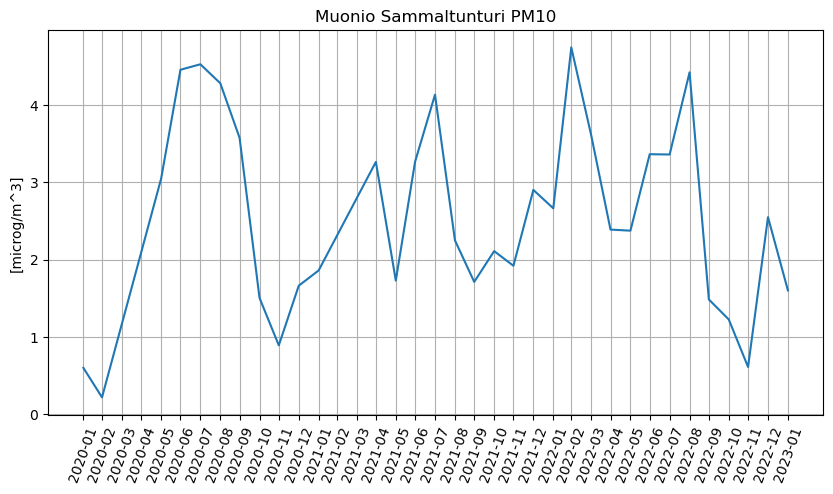

In [132]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.grid(True)
ax.set_title('Muonio Sammaltunturi PM10')
ax.set_ylabel('[microg/m^3]')
ax.set_xticks(muonio_months_df.index)
ax.set_xticklabels(muonio_months_df.index, rotation=70)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.plot(muonio_months_df.dropna())


## References
* [Fazzini et al. - Forecasting PM10 Levels Using Machine Learning Models in the Arctic: A Comparative Study](https://www.mdpi.com/2072-4292/15/13/3348)  
* [ECMWF - CAMS Regional: European air quality analysis and forecast data documentation](https://confluence.ecmwf.int/display/CKB/CAMS+Regional%3A+European+air+quality+analysis+and+forecast+data+documentation)